## EDA

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from google.colab import drive
drive = drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/시계열 스터디/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [ ]:
data['Month'] = pd.to_datetime(data.Month)
data = data.set_index(data.Month)
data.drop(columns = ['Month'], axis = 1, inplace = True)
data.head()


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
ts = data['#Passengers']
type(ts)

pandas.core.series.Series

In [ ]:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

데이트타임 타입을 인덱스로 변환시 1949년에 해당하는 데이터만 선택도 가능하다.

In [ ]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

데이터셋이 정상성 (Stationary)인지의 검증을 위해 plt.plot을 사용한다.

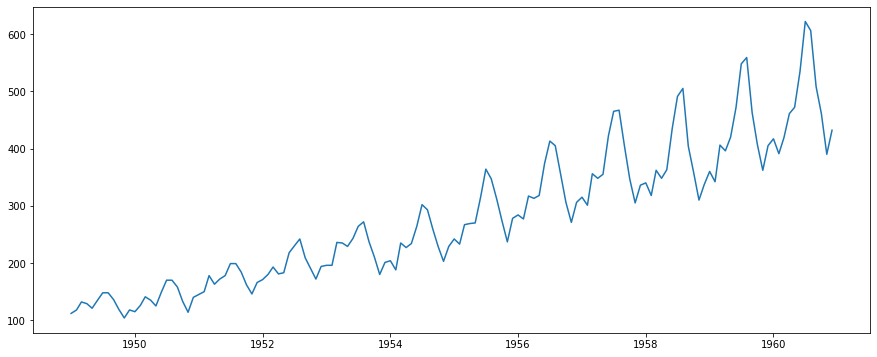

In [ ]:
rcParams['figure.figsize'] = 15, 6
#matplotlib에서 Runtime Configuration Parameters라는 딕셔너리의 값을 이용해 그린다.
#기본 figure size를 (15, 6)으로 세팅하는 개념
plt.plot(ts)

<AxesSubplot:ylabel='Density'>

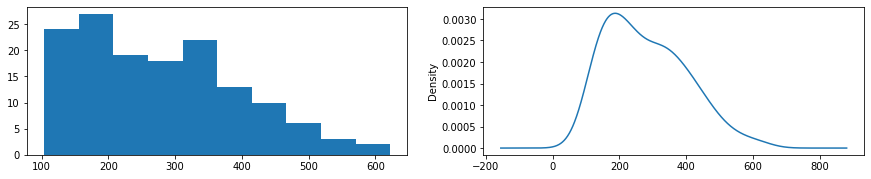

In [ ]:
plt.subplot(2,2,1) #plt.subplot(221) #nrows, ncols, nindex
plt.hist(ts)
plt.subplot(2,2,2)
ts.plot(kind = 'kde')

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
  rolmean = timeseries.rolling(window = 12).mean() #12개 단위로 평균 계산
  rolstd = timeseries.rolling(window = 12).std() #12개 단위로 표준편차 계산

  orig = plt.plot(timeseries, color= "blue", label = "Original")
  mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
  st = plt.plot(rolstd, color = 'black', label = 'Roling std')
  plt.legend(loc = 'best') #최적의 위치에 legend 배치
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries) #디키풀러 검정
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


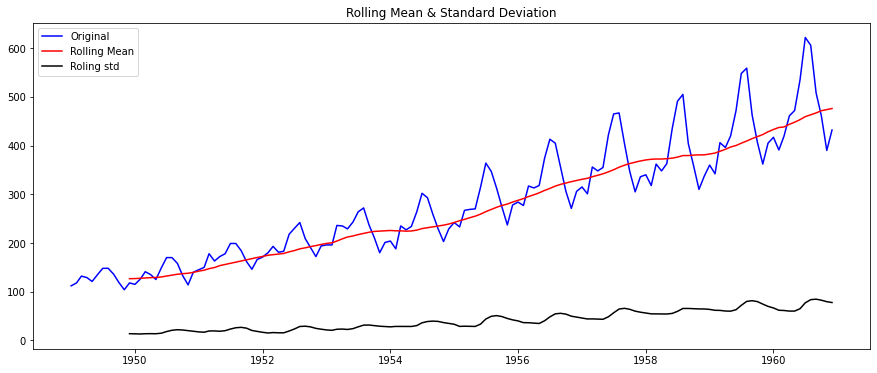

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationarity(ts)

P-value 만 봐도 기각. 즉 stationary가 아니다.

## Series를 Stationary하게 바꿔보자

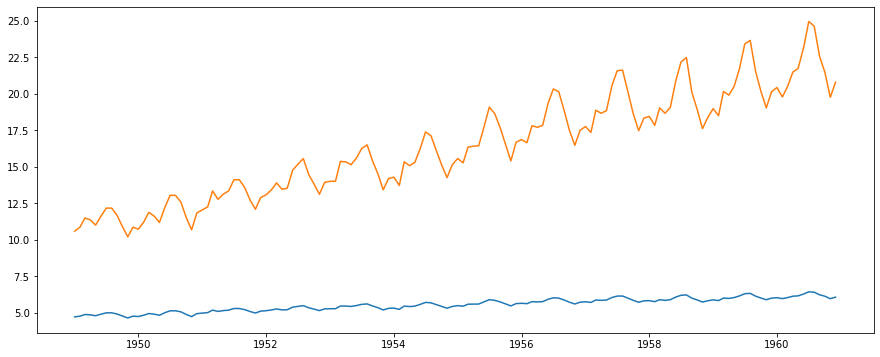

In [ ]:
ts_log = np.log(ts)
ts_root = np.sqrt(ts)
plt.plot(ts_log)
plt.plot(ts_root)

Aggregation – taking average for a time period like monthly/weekly averages

Smoothing – taking rolling averages

Polynomial Fitting – fit a regression model

### Moving Average

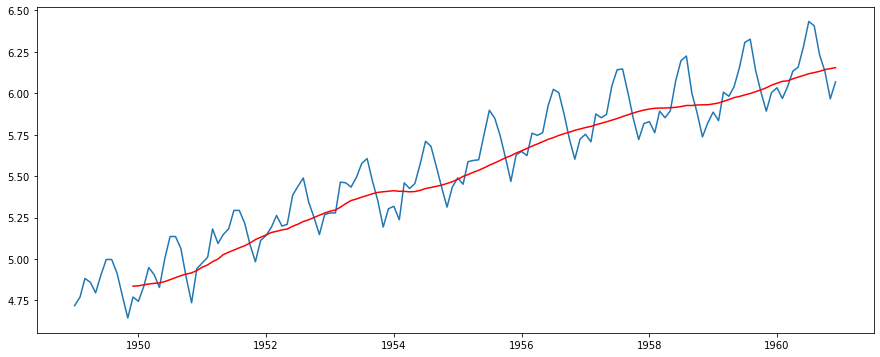

In [ ]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff[ts_log_moving_avg_diff.isna()]

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
1949-06-01   NaN
1949-07-01   NaN
1949-08-01   NaN
1949-09-01   NaN
1949-10-01   NaN
1949-11-01   NaN
Name: #Passengers, dtype: float64

In [ ]:
ts_log_moving_avg_diff.dropna(inplace=True) #초반 11개의 데이터는 결과가 나오지 않으므로

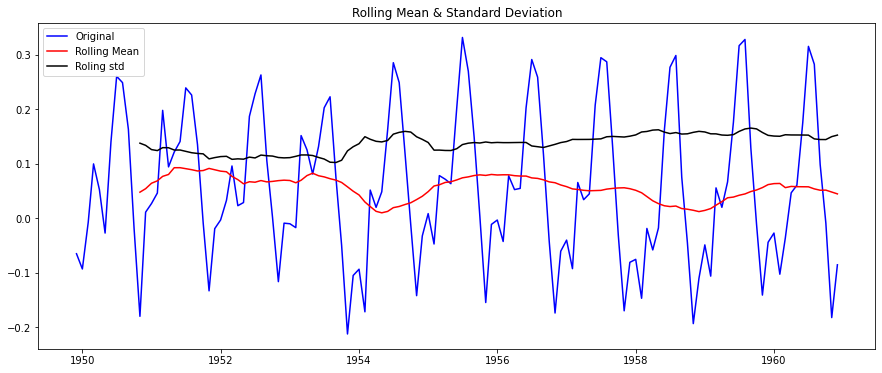

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
test_stationarity(ts_log_moving_avg_diff)

In [ ]:
# test statistic 이 critical value 5%보다 적음.
# p value 역시 충분히 작다. 
# 추세란 평균의 이동이기 때문에 롤링 평균을 제거해 주는 것 만으로도 추세를 충분히 제거할 수 있음

### EWMA

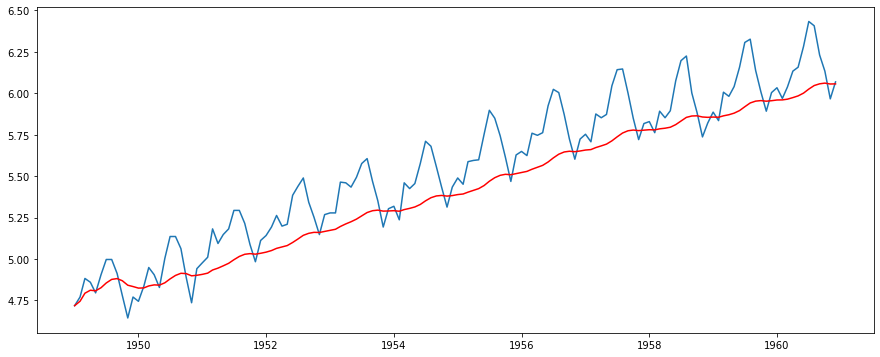

In [ ]:
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'red')

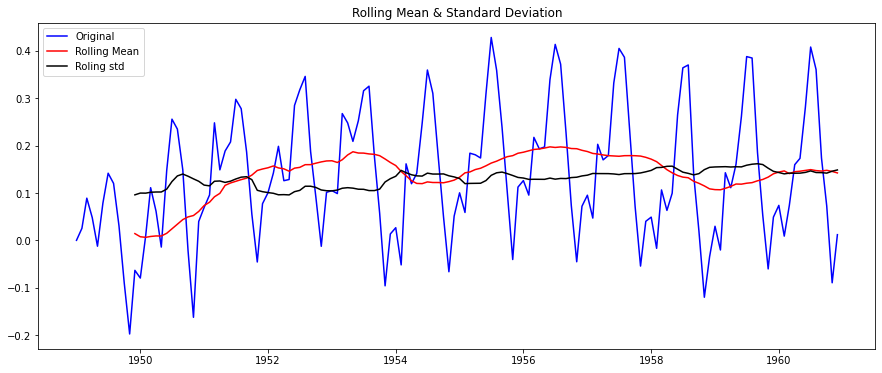

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
ts_log_ema_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ema_diff)

확실히 EWMA에서 variation 이 더 적게 나옴. 유의수준도 0.01보다 적게 나왔다.

## 모델의 trend와 seasonality를 제거해 보자
- 차분
- 분해법

### 차분 Differencing

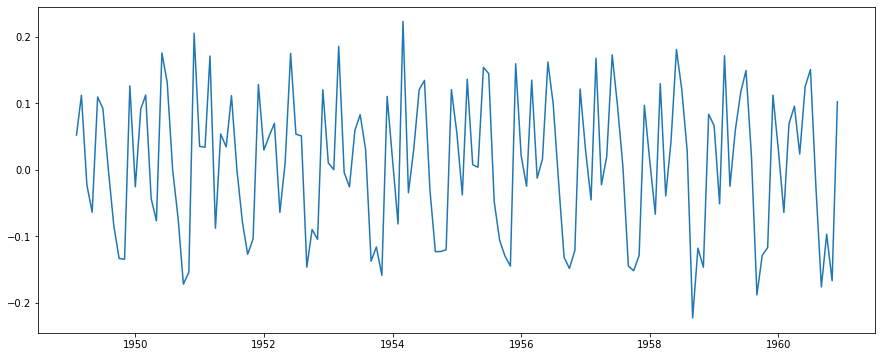

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

<AxesSubplot:xlabel='Month'>

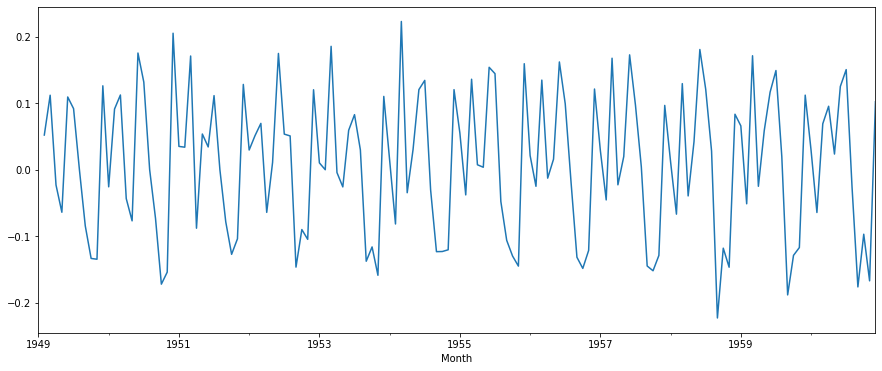

In [ ]:
ts_log.diff().plot() #같은 결과

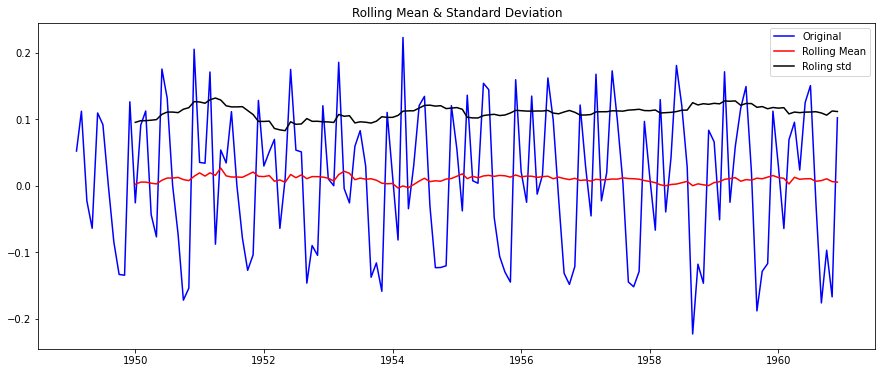

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### 2차 차분도 구해보자

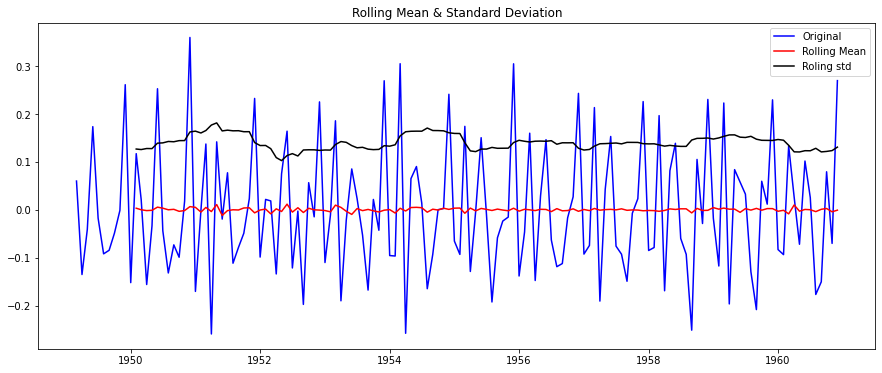

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [ ]:
ts_log_double_diff = (ts_log - ts_log.shift()) - (ts_log.shift() - ts_log.shift().shift())
ts_log_double_diff.dropna(inplace = True)
test_stationarity(ts_log_double_diff)


### Decomposing

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

ImportError: ignored

In [ ]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)
test_stationarity(ts_log_decompose) #trend, seasonality 를 제외한 residual -> stationality 성립한다.

## Model 구현하기 ARMA

### ACF/PartialACF

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

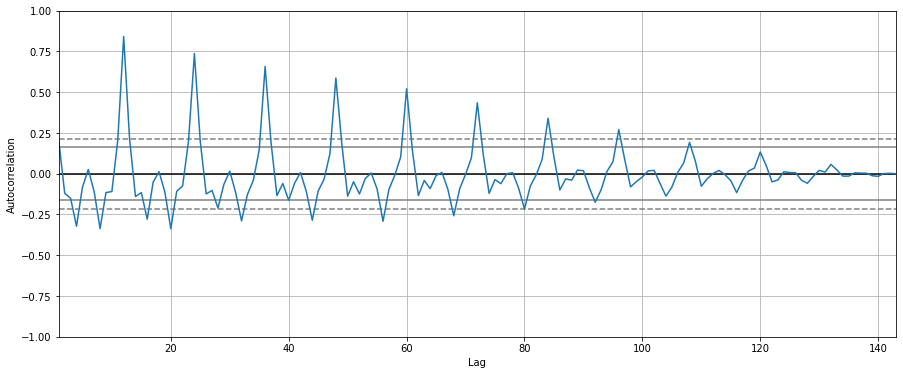

In [ ]:
pd.plotting.autocorrelation_plot(ts_log_diff)

자기상관관계가 1. Seasonal 하며, 2. 서서히 줄어든다. 

*seasonality 때문에 12 lag 시점의 autocorrelation이 높게 잡힌다.*

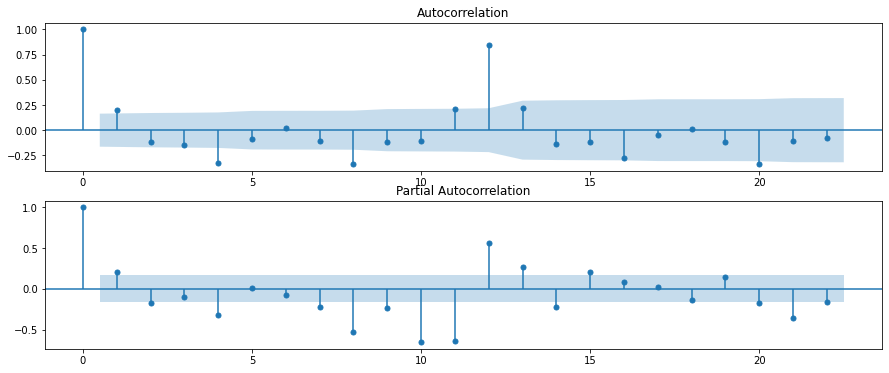

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca())
plt.show()

ACF, PACF plotting 하는 다른 방법

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20, method = 'ols')

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


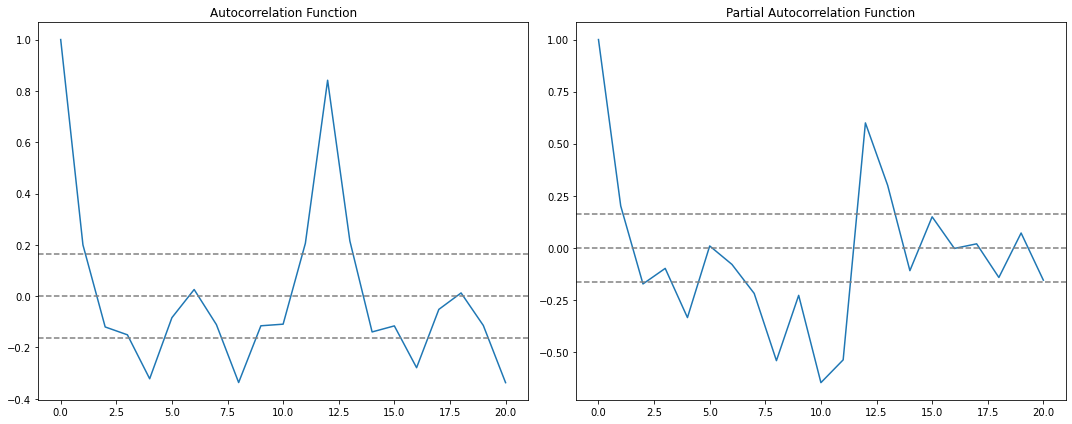

In [ ]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

In [ ]:
pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


재시작해야됨

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

Text(0.5, 1.0, 'RSS: 1.5023')

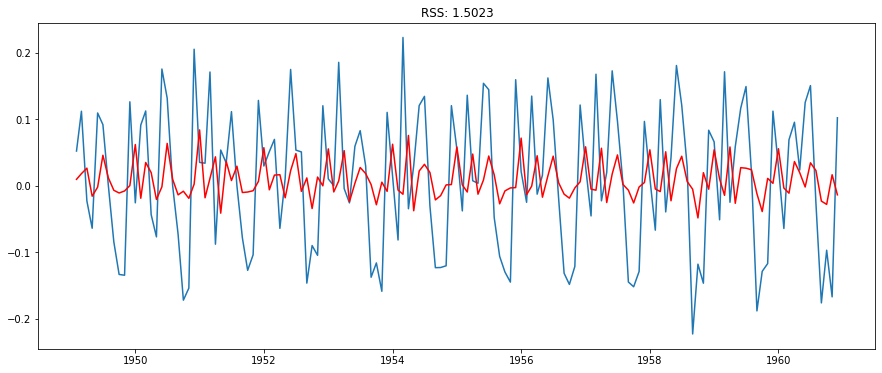

In [ ]:
model = ARIMA(ts_log, order = (2,1,0))
results_AR = model.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 1.4721')

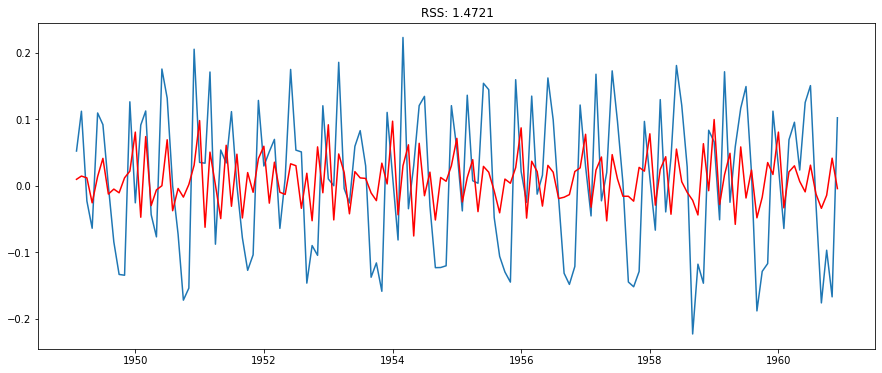

In [ ]:
model = ARIMA(ts_log, order= (0, 1, 2))  
results_MA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ts_log_diff)**2))

여기서부터는 다음 주 내용